In [6]:
# Select device
DEVICE = "CPU"
# DEVICE = "CUDA"

ort_EP = f"{DEVICE}ExecutionProvider"

In [7]:
# Load dataset
from torch.utils.data import DataLoader
from dataset_classes import SatImgDataset
from utils import utils
import torch

BATCH_SIZE = 1
DATASET_FILEPATH = "./test_dataset.pkl"

dataset = utils.read_object(DATASET_FILEPATH)
loader = DataLoader(dataset, BATCH_SIZE, shuffle=False)

def to_numpy(tensor):
    tensor = tensor.detach() if tensor.requires_grad else tensor
    return tensor.numpy()

In [8]:
# Check onnx model
import onnx

# ONNX_MODEL_FILEPATH = f"./onnx_models/sat6-cnn-t1w8.onnx" 
ONNX_MODEL_FILEPATH = f"./onnx_models/sat6-cnn-t1.onnx"

onnx_model = onnx.load(ONNX_MODEL_FILEPATH)
onnx.checker.check_model(onnx_model)

In [9]:
# Start inference session
import onnxruntime as rt
import numpy as np

sess = rt.InferenceSession(ONNX_MODEL_FILEPATH)

# print(sess.get_providers())

sess.set_providers([ort_EP])

def model_inference(numpy_input):
    pred = sess.run(None, {"modelInput": numpy_input})[0]
    return np.argmax(pred, 1)

In [10]:
# Accuracy measure

import numpy as np
from tqdm import tqdm

correct = 0
i = 0
for batch in tqdm(loader):
    predicted = torch.from_numpy(model_inference(to_numpy(batch['x'])))
    real_class = torch.max(batch['y'], 1)[1]
    correct += (predicted == real_class).sum()

accuracy = correct.item()/len(dataset)*100
print("Acuracy: ", accuracy, " %")

100%|██████████| 81000/81000 [00:07<00:00, 11530.56it/s]

Acuracy:  95.85925925925926  %


Latencia média:  17.928619249883013 us
Latencia mínima: 14.990999716246733 us
Latencia máxima: 1160.0369998632232 us
Desvio Padrão:   7.284961801327252 us
Mediana:         17.27800008666236 us


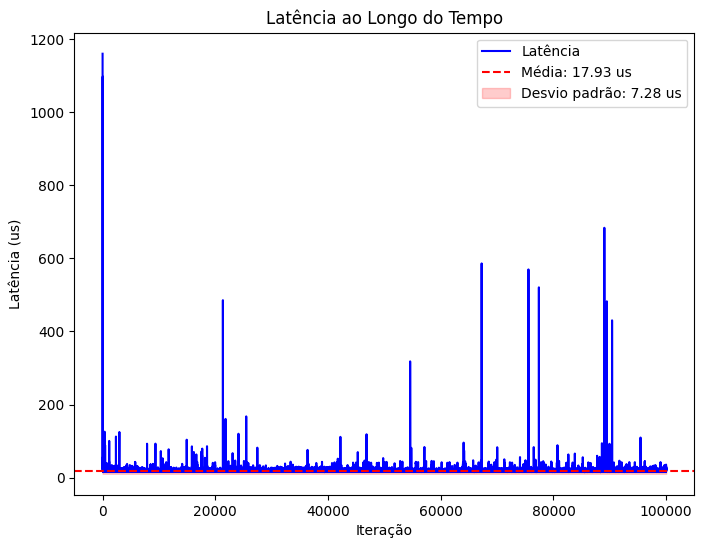

In [14]:
# Latency measure

from utils import plots
from timeit import Timer  

measure_code = "prediction = model_inference(ort_in)"
setup_code   = "ort_in = to_numpy(torch.rand([1, 4, 32, 32]))"
# setup_code   = "ort_in = next(iter(loader))['x']"

timer = Timer(measure_code, setup=setup_code, globals=globals())
latency_array = np.array(timer.repeat(100000, number=1)) * 1e6

print(f"Latencia média:  {np.mean(latency_array)} us")
print(f"Latencia mínima: {np.min(latency_array)} us")
print(f"Latencia máxima: {np.max(latency_array)} us")
print(f"Desvio Padrão:   {np.std(latency_array)} us")
print(f"Mediana:         {np.median(latency_array)} us")

plots.time_plot(latency_array, "Latência", "us")
# plots.histogram_plot(latency_array, "Latência", "us")


In [15]:
# Throughput measure
import pandas as pd

measure_code = "prediction = model_inference(ort_in)"
# setup_code   = "ort_in = next(iter(loader))['x']"

results_dict = {"batch_size": [], "mean" : [], "min" : [], "max": [], "std": [], "median" : [], "throughput": [] }

for batch_size in tqdm(range(1, 1000, 10)):
    # dataset = utils.read_objectDATASET_FILEPATH)
    # loader = DataLoader(dataset, batch_size, shuffle=False)
    setup_code   = f"ort_in = to_numpy(torch.rand([{batch_size}, 4, 32, 32]))"
    
    timer = Timer(measure_code, setup=setup_code, globals=globals())
    latency_array = np.array(timer.repeat(int(100000/batch_size), number=1)) * 1e3

    mean_latency = np.mean(latency_array)  
    throughput = batch_size / (mean_latency * 1e-3)  
    
    results_dict["batch_size"].append(batch_size)
    results_dict["mean"].append(mean_latency)
    results_dict["throughput"].append(throughput)
    results_dict["min"].append(np.min(latency_array))
    results_dict["max"].append(np.max(latency_array))
    results_dict["std"].append(np.std(latency_array))
    results_dict["median"].append(np.median(latency_array))


df_results = pd.DataFrame(results_dict)


100%|██████████| 100/100 [02:55<00:00,  1.75s/it]


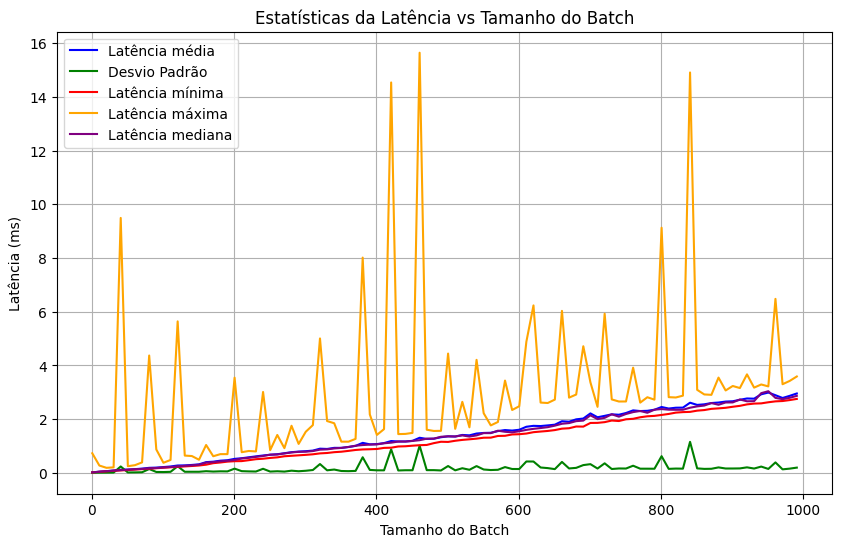

In [16]:
# Latency plot
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

plt.plot(df_results["batch_size"], df_results["mean"],   label="Latência média",   color="b")
plt.plot(df_results["batch_size"], df_results["std"],    label="Desvio Padrão",    color="g")
plt.plot(df_results["batch_size"], df_results["min"],    label="Latência mínima",  color="r")
plt.plot(df_results["batch_size"], df_results["max"],    label="Latência máxima",  color="orange")
plt.plot(df_results["batch_size"], df_results["median"], label="Latência mediana", color="purple")

plt.xlabel("Tamanho do Batch")
plt.ylabel("Latência (ms)")
plt.title("Estatísticas da Latência vs Tamanho do Batch")
plt.legend()
plt.grid(True)

plt.show()

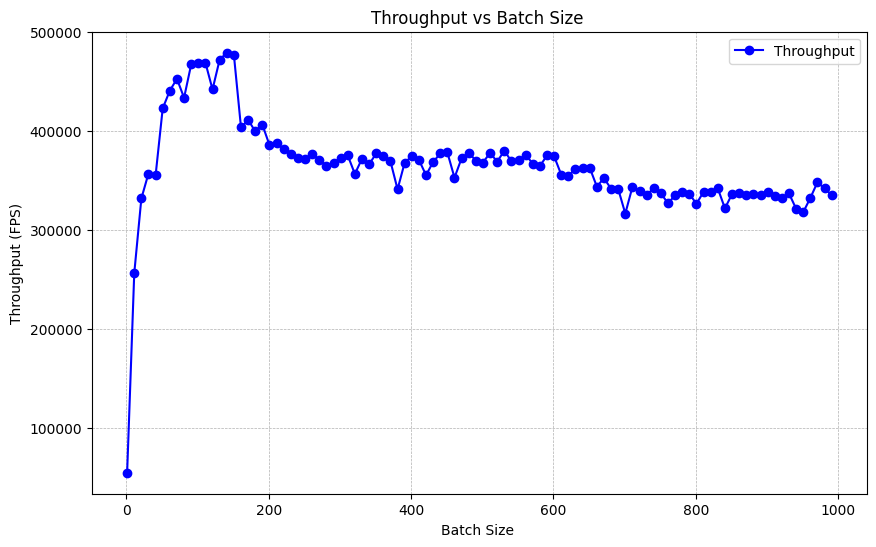

In [17]:
# Throughput plot
plt.figure(figsize=(10, 6))

plt.plot(df_results["batch_size"], df_results["throughput"], label="Throughput", color="b", marker='o')

plt.xlabel("Batch Size ")
plt.ylabel("Throughput (FPS)")
plt.title("Throughput vs Batch Size ")
plt.legend()
plt.grid(True, which="both", ls="--", lw=0.5)  

plt.show()

In [24]:
# Power measurement (CPU and GPU with volta architecture only)
# TODO: Take GPU measure from df

from pyJoules.energy_meter import EnergyContext
from pyJoules.handler.pandas_handler import PandasHandler

pandas_handler = PandasHandler()

ort_in = to_numpy(torch.rand([1000, 4, 32, 32]))


for i in range(100):
	with EnergyContext(handler=pandas_handler):
		prediction = model_inference(ort_in)

df = pandas_handler.get_dataframe()

power = df['package_0'] / df['duration']
print("Average power: ", power.mean() / 1e6, " watts")

Average power:  30.839864192851785  watts
